In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import evaluate

/users/9/zhan7569/.conda/envs/CSCI5541/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset
from datasets import Dataset
from sklearn.model_selection import train_test_split

dataset = load_dataset("ealvaradob/phishing-dataset", "combined_reduced", trust_remote_code=True)

df = dataset['train'].to_pandas()
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, test = Dataset.from_pandas(train, preserve_index=False), Dataset.from_pandas(test, preserve_index=False)

all records are labeled as 1 (Phishing) or 0 (Benign).

Load the tokenizer and the model

In [3]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

/users/9/zhan7569/.conda/envs/CSCI5541/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenize the datasets

In [4]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

train = train.map(tokenize_function, batched=True)
test = test.map(tokenize_function, batched=True)

Map: 100%|██████████| 15536/15536 [01:46<00:00, 146.15 examples/s]


Define the data collator

In [5]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Define the evaluation metric using 'evaluate'

In [6]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix  # <-- Add this line

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    
    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)

    # Calculate confusion matrix to get False Positive Rate
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "false_positive_rate": fpr
    }


Set up training arguments

In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,False Positive Rate
1,0.087300,0.174723,0.969233,0.964719,0.962062,0.025558
2,0.048600,0.155133,0.970391,0.964389,0.965275,0.025892
3,0.024400,0.182384,0.972387,0.975405,0.958544,0.017558


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=11652, training_loss=0.05344175252970084, metrics={'train_runtime': 4669.7617, 'train_samples_per_second': 39.921, 'train_steps_per_second': 2.495, 'total_flos': 4.904995227337728e+16, 'train_loss': 0.05344175252970084, 'epoch': 3.0})

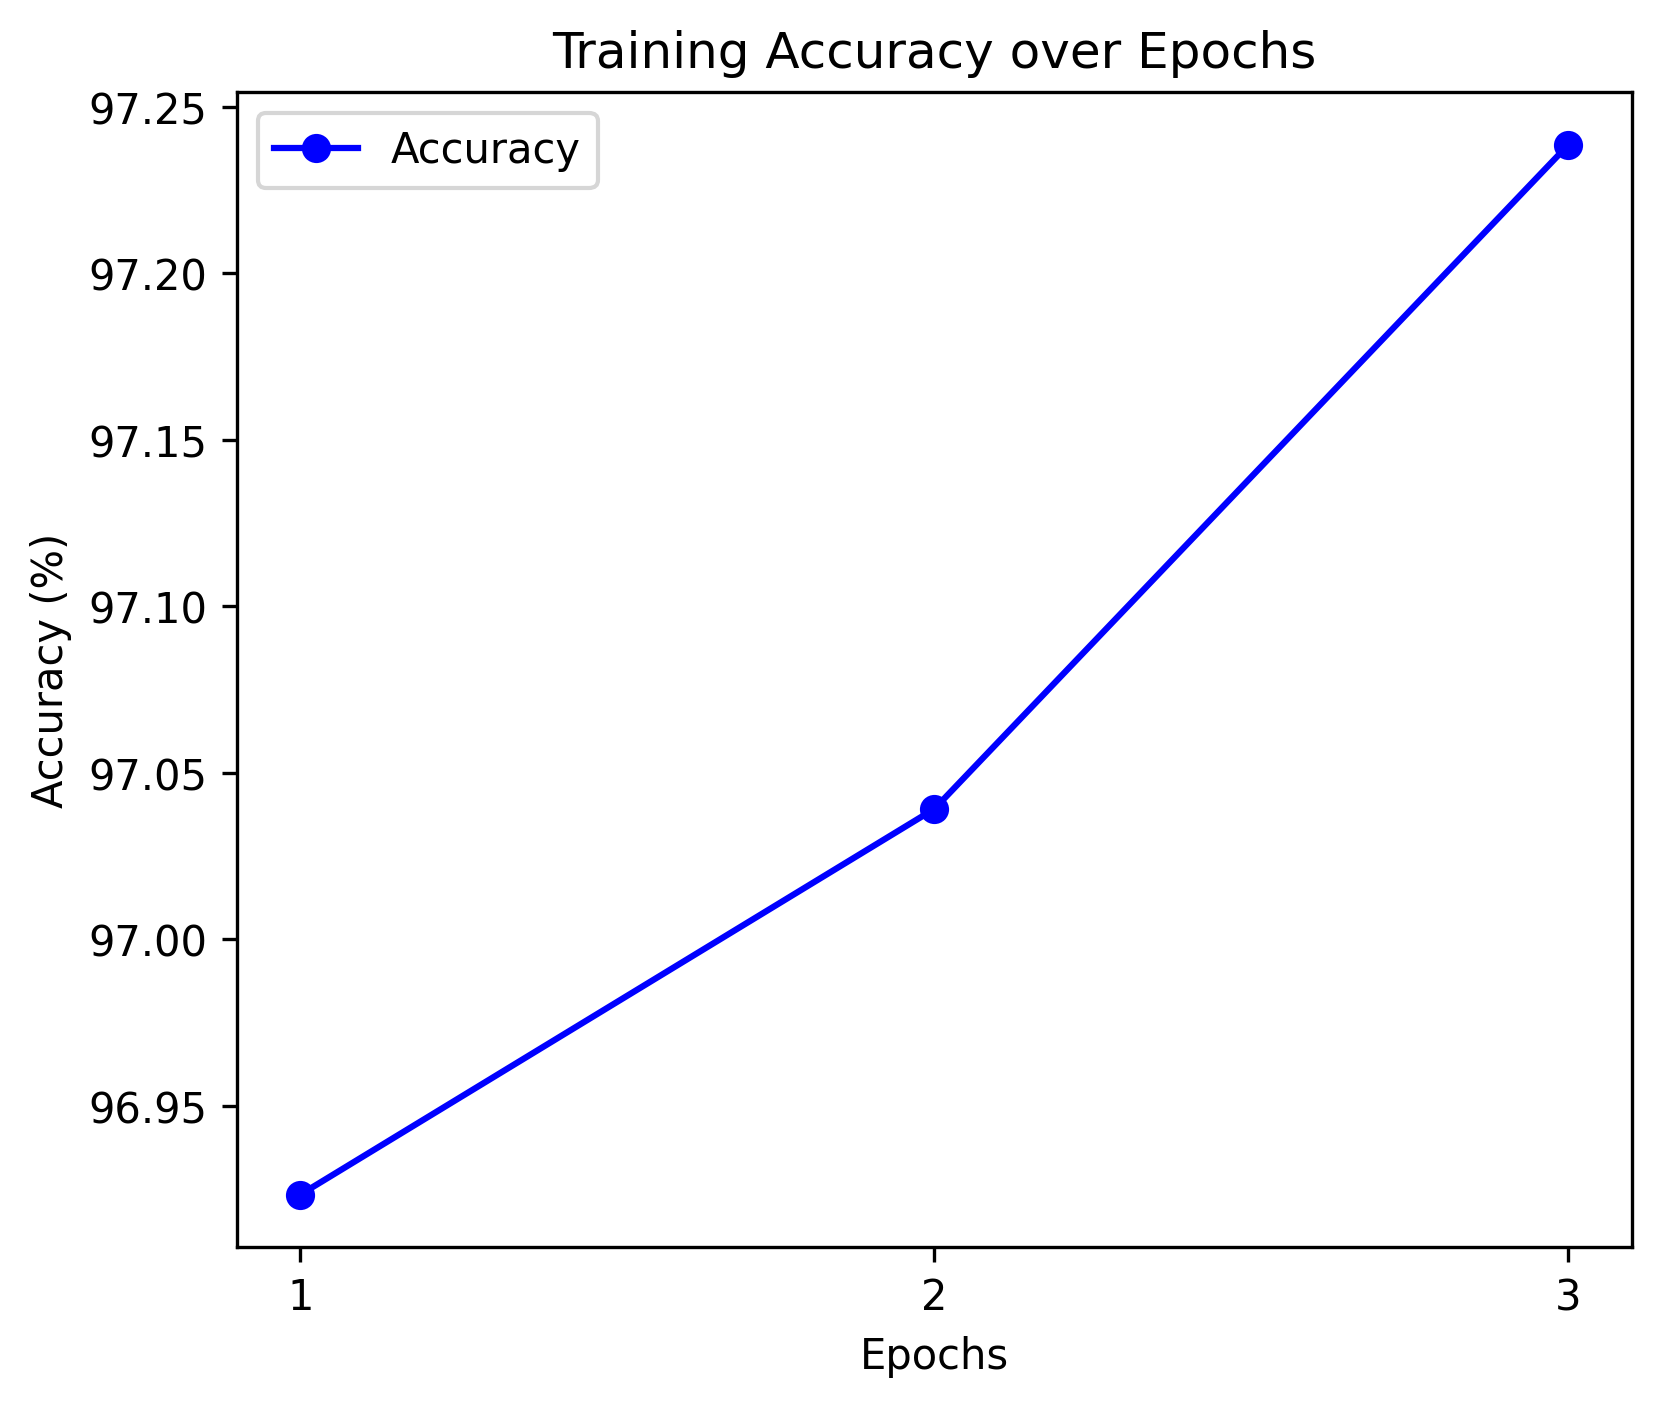

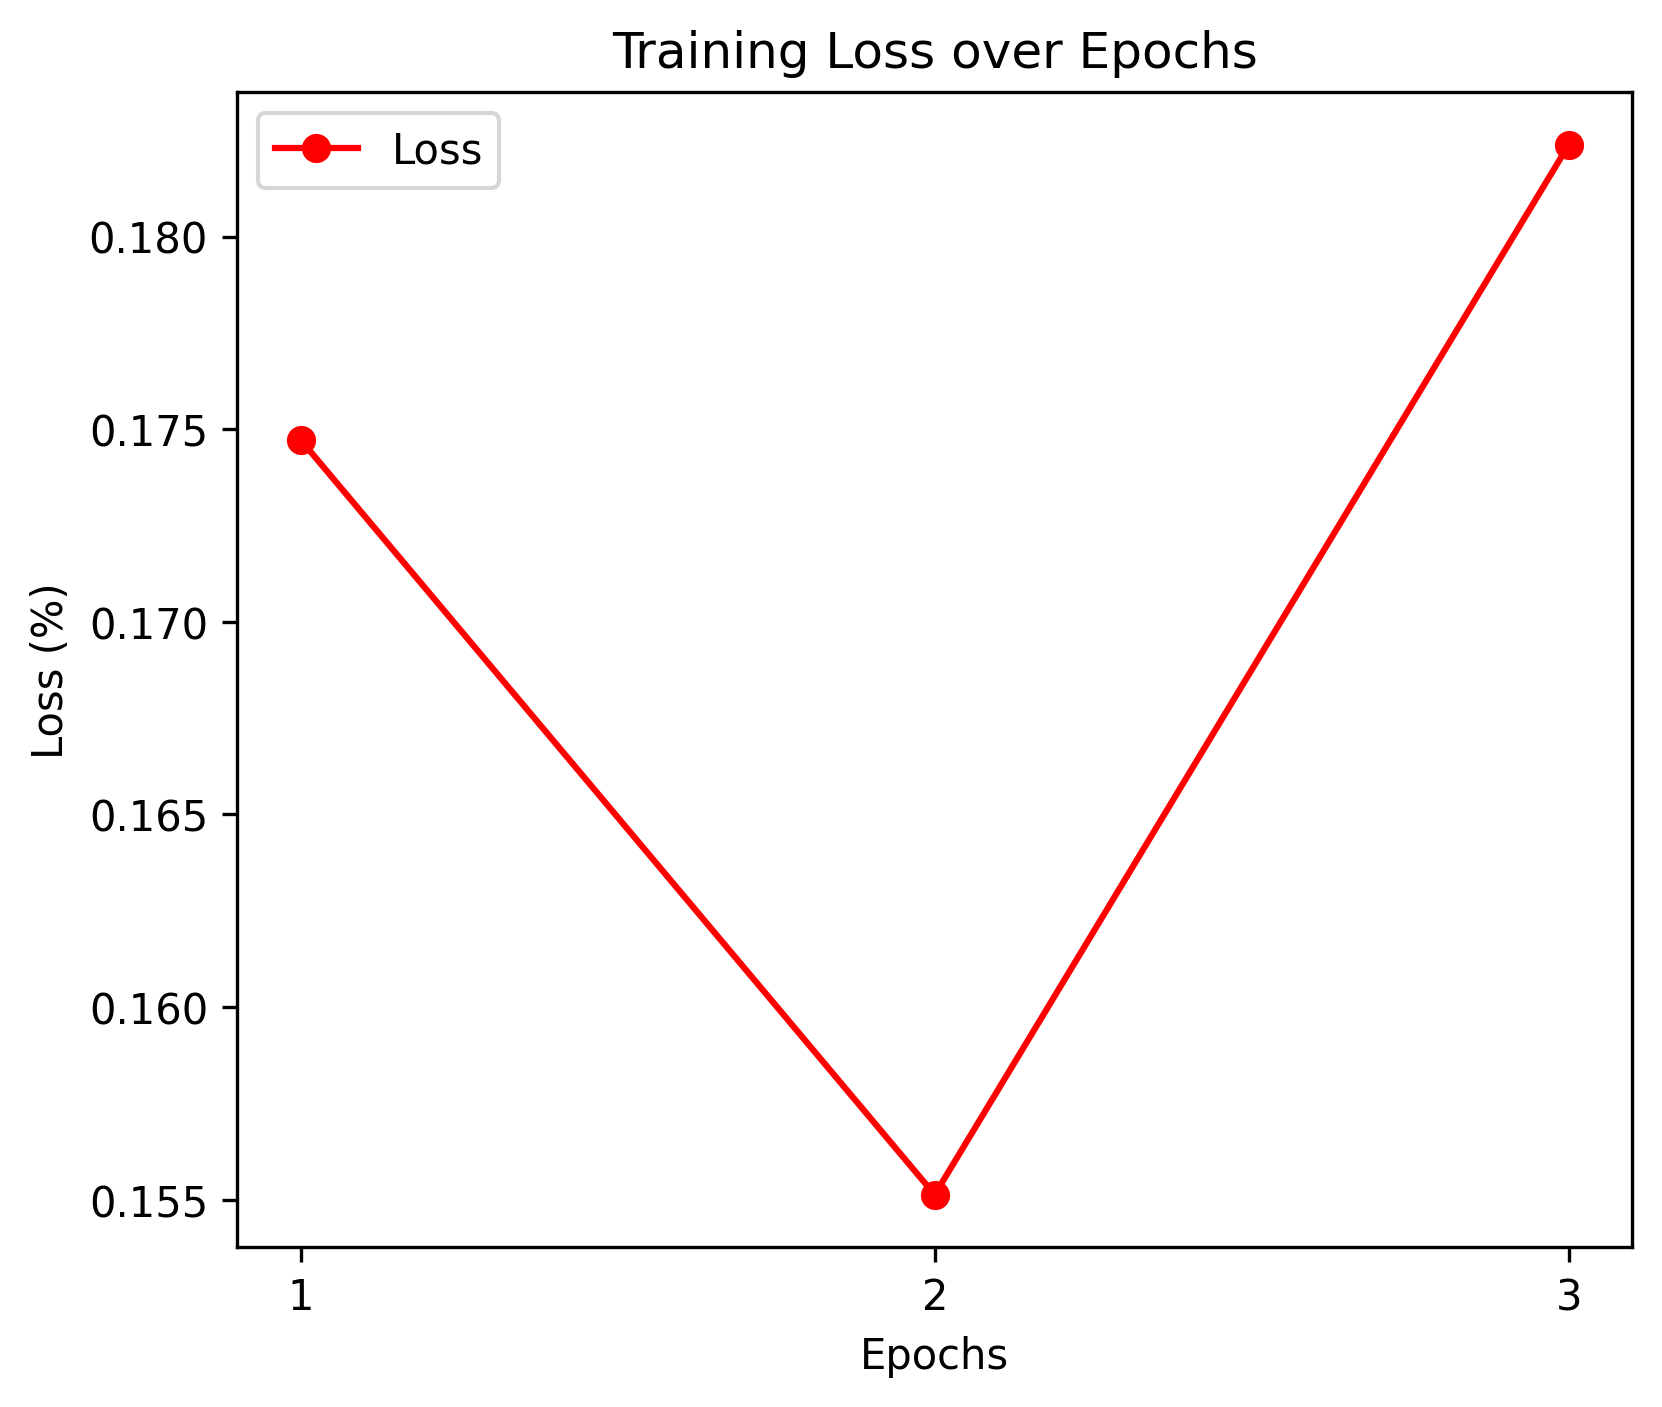

In [31]:
import matplotlib.pyplot as plt

# Convert accuracy and loss values to percentages
accuracies_percentage = [acc * 100 for acc in accuracies]

# Plotting Accuracy over Epochs with modified axes
plt.figure(figsize=(6, 5), dpi=300)
plt.plot(epochs, accuracies_percentage, marker='o', color='b', label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy over Epochs")
plt.xticks([1, 2, 3])  # Set x-axis to show 1, 2, 3
plt.legend()
plt.savefig('acuracy.jpg')
plt.show()

# Plotting Loss over Epochs with modified axes
plt.figure(figsize=(6, 5), dpi=300)
plt.plot(epochs, losses, marker='o', color='r', label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.title("Training Loss over Epochs")
plt.xticks([1, 2, 3])  # Set x-axis to show 1, 2, 3
plt.legend()
plt.savefig('loss.jpg')
plt.show()


In [32]:
# Choose a directory to save the model
output_dir = "./fine_tuned_roberta_model"

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


('./fine_tuned_roberta_model/tokenizer_config.json',
 './fine_tuned_roberta_model/special_tokens_map.json',
 './fine_tuned_roberta_model/vocab.json',
 './fine_tuned_roberta_model/merges.txt',
 './fine_tuned_roberta_model/added_tokens.json')

Load the model

In [34]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load the model and tokenizer
model = RobertaForSequenceClassification.from_pretrained(output_dir)
tokenizer = RobertaTokenizer.from_pretrained(output_dir)

# Ensure the model is in evaluation mode
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [37]:
import pandas as pd

csv_path = "ronit_phishing_examples_4th_run.csv"  # Replace with your CSV file path
df = pd.read_csv(csv_path)
df.rename(columns={"Examples": "text", "Labels": "label"}, inplace=True)

# Convert the DataFrame to a Hugging Face Dataset
new_dataset = Dataset.from_pandas(df, preserve_index=False)


In [39]:
# Step 3: Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

new_dataset = new_dataset.map(tokenize_function, batched=True)
new_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map: 100%|██████████| 2077/2077 [00:00<00:00, 7743.02 examples/s]


In [41]:
import torch
# Step 4: Make predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in new_dataset:
        input_ids = batch["input_ids"].unsqueeze(0)
        attention_mask = batch["attention_mask"].unsqueeze(0)
        labels = batch["label"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).item()

        all_preds.append(predictions)
        all_labels.append(labels.item())

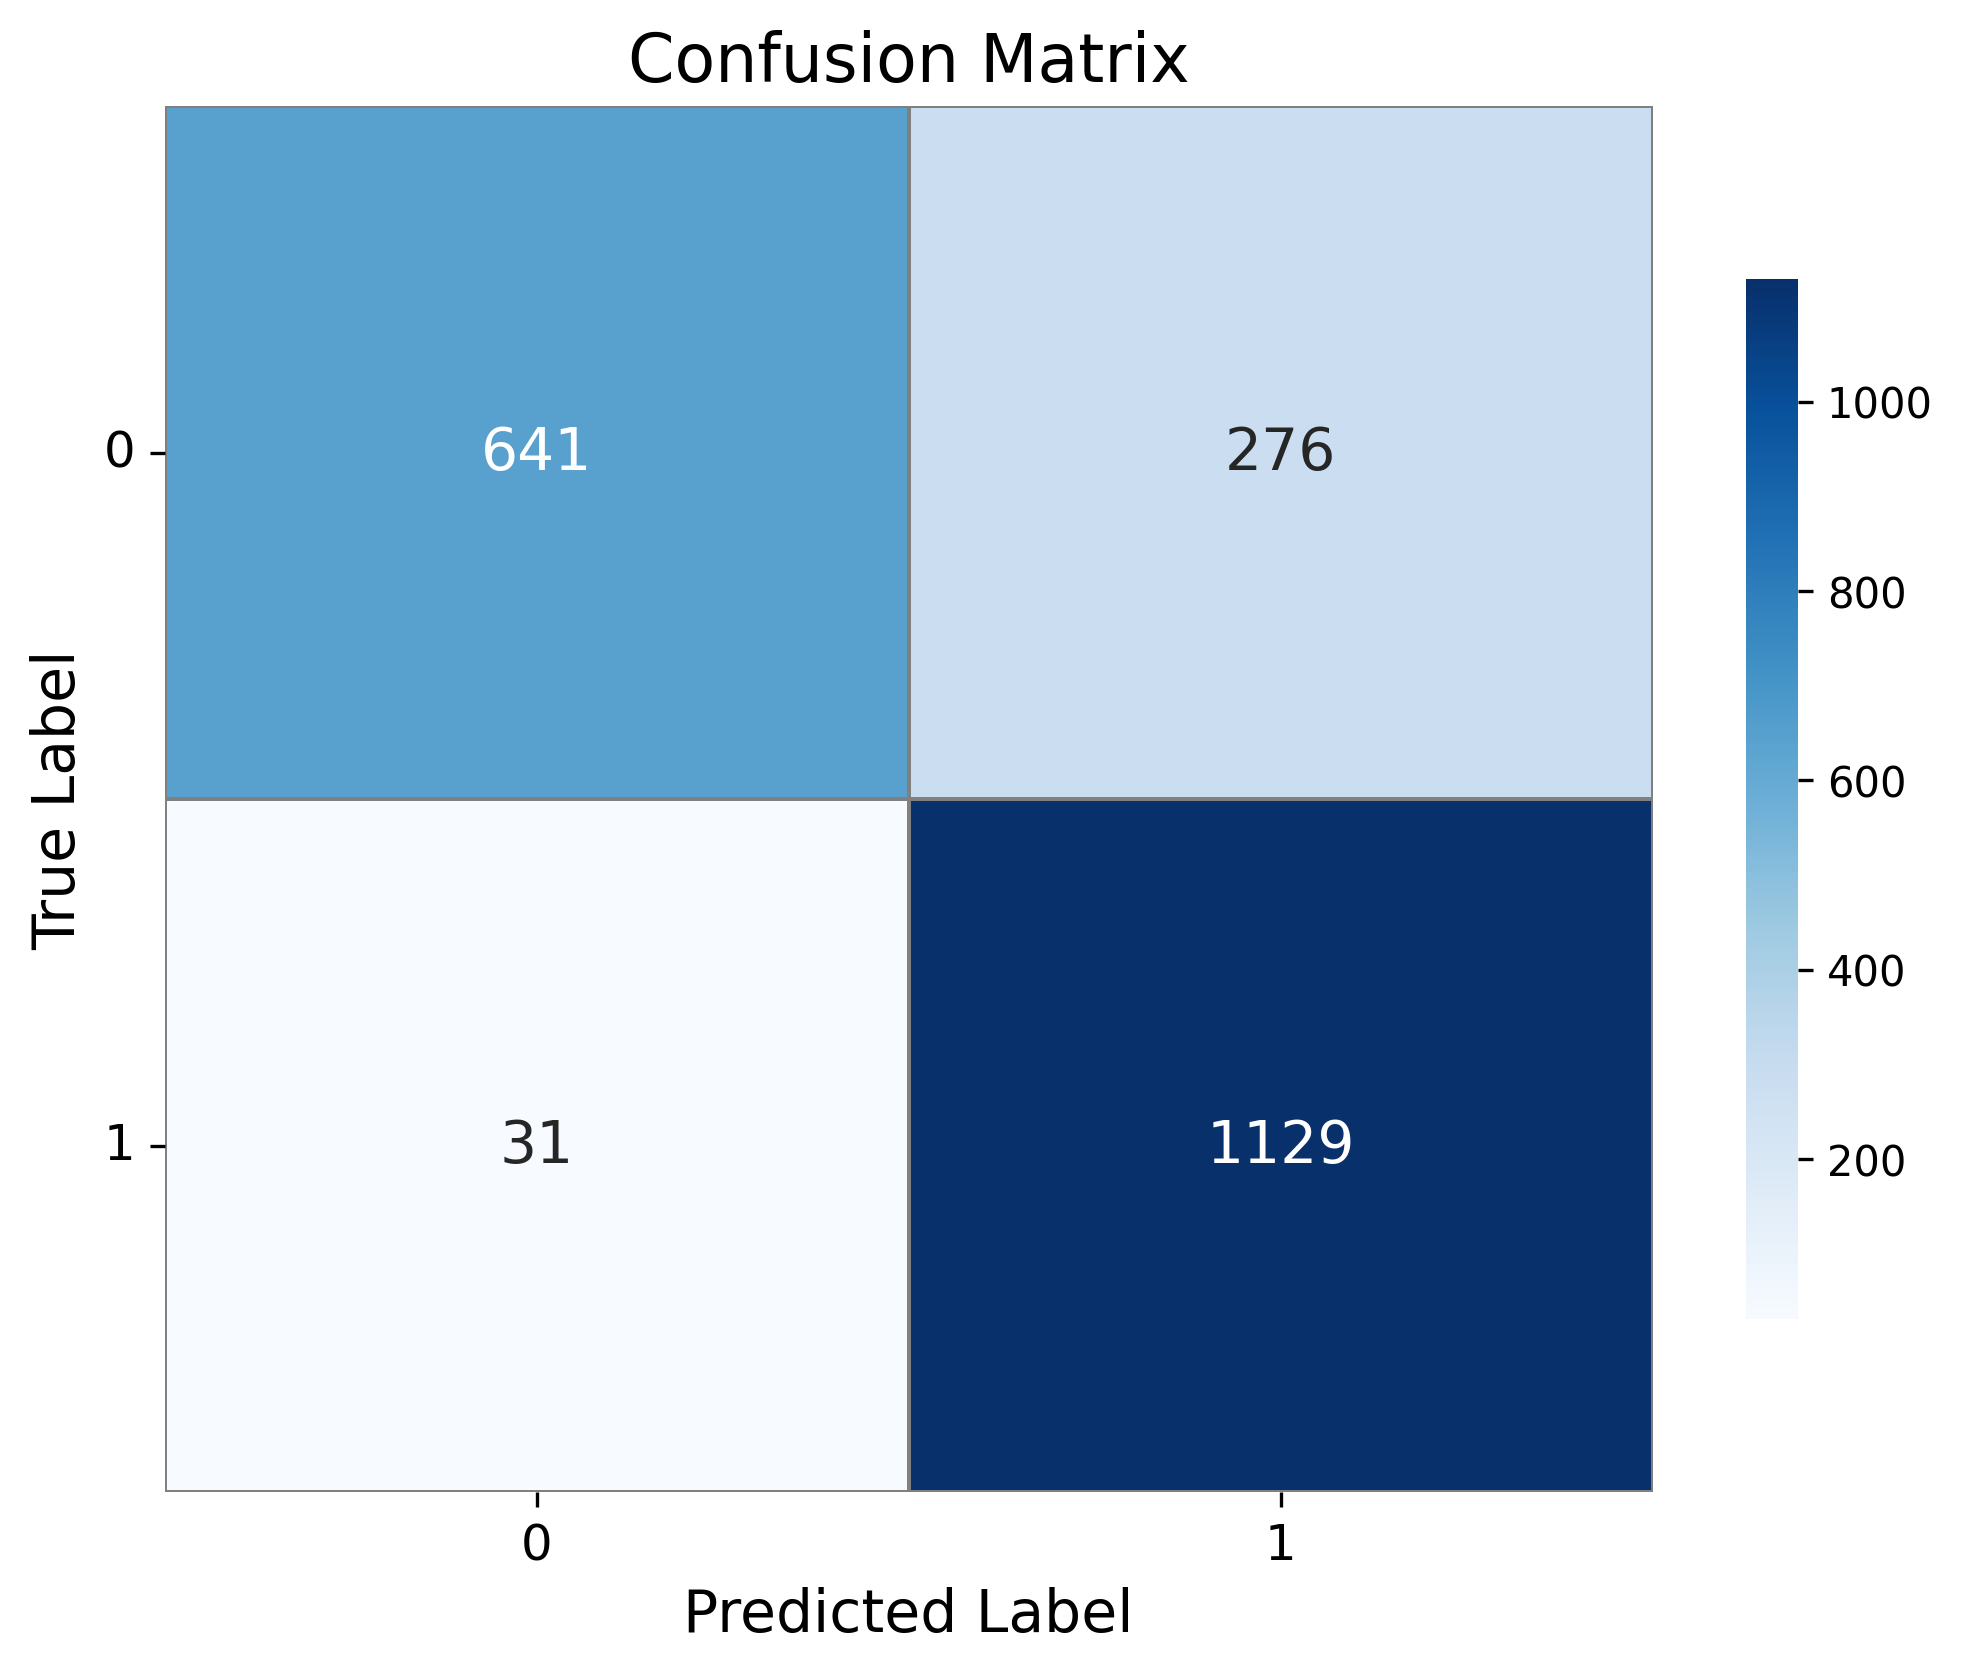

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix data
cm = confusion_matrix(all_labels, all_preds)

# Customize the appearance with seaborn heatmap
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    linewidths=0.5, 
    linecolor='gray', 
    cbar_kws={'shrink': 0.75},
    annot_kws={"size": 14}
)

# Add labels and titles for clarity
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], fontsize=12, rotation=0)

plt.savefig('ConfusionMatrix.jpg')
# Display the improved confusion matrix
plt.show()


In [48]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])

# Print the report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.70      0.81       917
     Class 1       0.80      0.97      0.88      1160

    accuracy                           0.85      2077
   macro avg       0.88      0.84      0.84      2077
weighted avg       0.87      0.85      0.85      2077

